# Comece aqui

**Link do repositório**

[Projeto no GitHUB](https://github.com/DeyvidJLira/fiap-iadev-project-fase1)

**Como estar organizado**

Conforme pode ver na parte de conteúdo, temos 5 seções que são:


*  Passo 0: Setup - Destinado a criação de classes e configurações que serão utilizados por esse projeto;
*  Passo 1: Processamento dos dados - Destinado a fazer o processamento inicial dos dados (raw.csv) e então gerão o processed.csv;
*  Passo 2: Análise dos dados processados - Destinado a realizar análise dos dados processados (processed.csv);
*  Passo 3: Construindo o modelo - Destinado a geração dos modelos, devido ao TrainModel você pode gerar diferentes modelos para ver a eficiência de cada um;
*  App UI - Contém chamada à função de executar o app.

**Contexto**

Dado um conjunto fictício de dados, tentar prever o valor à ser pago de plano de saúde.

**Gostaria de fazer um primeiro teste? Após executar o 'Passo 0: Setup' por completo, tente executar o código a seguir:**


In [7]:
build_and_start_app()

# Passo 0: Setup

## Prepare environment

In [1]:
from pathlib import Path

!pip install scikit-learn==1.2.2

def setup():
  if not Path('data/raw.csv').is_file():
    !mkdir data
    %cd data
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/data/raw.csv'
    %cd ..
  !mkdir model
  %cd model

  if not Path('elastic_net_regression_model.pkl').is_file():
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/model/elastic_net_regression_model.pkl'
  if not Path('lasso_regression_model.pkl').is_file():
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/model/lasso_regression_model.pkl'
  if not Path('linear_regression_model.pkl').is_file():
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/model/linear_regression_model.pkl'
  if not Path('ridge_regression_model.pkl').is_file():
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/model/ridge_regression_model.pkl'
  if not Path('gradient_boosting_regressor_model.pkl').is_file():
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/model/gradient_boosting_regressor_model.pkl'
  if not Path('support_vector_regression_model.pkl').is_file():
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/model/support_vector_regression_model.pkl'
  if not Path('random_forest_regressor_model.pkl').is_file():
    !wget 'https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/model/random_forest_regressor_model.pkl'

  %cd ..

setup()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.11 requires scikit-learn>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
/content/data
--2024-07-28 17:59:49--  https://raw.githubusercontent.com/DeyvidJLira/fiap-iadev-project-fase1/main/data/raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54618 (53K) [text/plain]
Saving to: ‘raw.csv’

raw.csv   

## Criando as constantes

In [2]:
class Constants:
    MIN_AGE = 18
    MAX_AGE = 120
    MIN_IMC = 0.0
    MAX_IMC = 50.0
    MIN_CHILDREN = 0
    MAX_CHILDREN = 10
    SEXO_MAP = {
        "masculino": 0,
        "feminino": 1
    }
    FUMANTE_MAP = {
        "nao": 0,
        "sim": 1
    }
    REGIAO_MAP = {
        "norte": 0,
        "nordeste": 1,
        "centro oeste": 2,
        "sul": 3,
        "sudeste": 4
    }

## Criando a classe Util

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

class Util:

    @staticmethod
    def calculate_rmse(mse):
        return np.sqrt(mse)


    @staticmethod
    def calculate_mape(labels, predictions):
        errors = np.abs(labels - predictions)
        relative_errors = errors / np.abs(labels)
        mape = np.mean(relative_errors) * 100
        return mape

    @staticmethod
    def evaluate(model, x_test, y_test):
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = Util.calculate_rmse(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape =  Util.calculate_mape(y_test, y_pred)
        print(f'Mean squared error: {mse}')
        print(f'Sqrt Mean squared error: {rmse}')
        print(f'R2 score: {r2}')
        print(f'Mean absolute error: {mae}')
        print(f'MAPE: {mape:.2f}%')


## Criando a classe SaveManager

In [4]:
import joblib

class SaveModelManager:

    @staticmethod
    def save_model(model, filename):
        joblib.dump(model, f'model/{filename}')
        print(f'Saved model: {filename}')

    @staticmethod
    def load_model(filename):
        model = joblib.load(filename)
        return model

## Criando as classes TrainModel

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt

class TrainModelBase:

    def __init__(self, p_name):
        self.name_model = p_name
        self.model = None
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.random_state = 42


    def train(self, X, y, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=self.random_state)
        return self.x_train, self.x_test, self.y_train, self.y_test


    def get_train_result(self):
      print(len(self.x_train), "training +", len(self.x_test), "tests")
      print(len(self.y_train), "training +", len(self.y_test), "tests")
      return self.x_train, self.x_test, self.y_train, self.y_test


    def get_model(self):
        return self.model


    def evaluate(self):
        print(self.name_model)
        Util.evaluate(self.model, self.x_test, self.y_test)


    def evaluate_pred(self):
        y_pred = self.model.predict(self.x_test)
        plt.scatter(self.y_test, y_pred)
        plt.xlabel("Valores reais")
        plt.ylabel("Previsões")
        plt.title("Comparando")
        plt.show()


    def save(self):
        filename = self.name_model + '.pkl'
        SaveModelManager.save_model(self.model, filename)


class TrainModelLinearRegression(TrainModelBase):

    def generate_model(self):
        self.model = LinearRegression()
        self.model.fit(self.x_train, self.y_train)
        return self.model


class TrainModelRidgeRegression(TrainModelBase):

    def generate_model(self):
        self.model = Ridge(alpha=1.0, random_state=self.random_state)
        self.model.fit(self.x_train, self.y_train)
        return self.model


class TrainModelLassoRegression(TrainModelBase):

    def generate_model(self):
        self.model = Lasso(alpha=0.1, random_state=self.random_state)
        self.model.fit(self.x_train, self.y_train)
        return self.model


class TrainModelElasticNetRegression(TrainModelBase):

    def generate_model(self):
        self.model = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=self.random_state)
        self.model.fit(self.x_train, self.y_train)
        return self.model


class TrainModelGradientBoostingRegressor(TrainModelBase):

    def generate_model(self):
        self.model = GradientBoostingRegressor(random_state=self.random_state)
        self.model.fit(self.x_train, self.y_train)
        return self.model


class TrainModelSupportVectorRegression(TrainModelBase):

    def generate_model(self):
        self.model = SVR(kernel='linear')
        self.model.fit(self.x_train, self.y_train)
        return self.model


class TrainModelRandomForestRegressor(TrainModelBase):

    def generate_model(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=self.random_state)
        self.model.fit(self.x_train, self.y_train)
        return self.model



## Criando o App UI

In [6]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import os

def build_and_start_app():
  model_list = os.listdir('model')
  model_list = [file for file in model_list if file.endswith('.pkl')]

  title = widgets.HTML(
      value="<h1 style='text-align: center;'>Previsão de custo de plano de saúde",
      layout=widgets.Layout(margin='10px 0px')
  )
  model_widget = widgets.Dropdown(options=model_list, description='Modelo:',layout=widgets.Layout(width='75%'))
  idade_widget = widgets.IntSlider(value=25, min=Constants.MIN_AGE, max=Constants.MAX_AGE, description='Idade:',layout=widgets.Layout(width='75%'))
  sexo_widget = widgets.Dropdown(options=Constants.SEXO_MAP.items(), description='Sexo:',layout=widgets.Layout(width='75%'))
  imc_widget = widgets.FloatSlider(value=25.0, min=Constants.MIN_IMC, max=Constants.MAX_IMC, description='IMC:',layout=widgets.Layout(width='75%'))
  criancas_widget = widgets.Dropdown(options=list(range(10)), description='Nº crianças:',layout=widgets.Layout(width='75%'))
  fumante_widget = widgets.Dropdown(options=Constants.FUMANTE_MAP.items(), description='Fumante:',layout=widgets.Layout(width='75%'))
  regiao_widget = widgets.Dropdown(options=Constants.REGIAO_MAP.items(), description='Região:',layout=widgets.Layout(width='75%'))
  submit_button = widgets.Button(description="Prever custo", button_style='success', icon='check',layout=widgets.Layout(width='75%'))

  output_result_label = widgets.HTML(
      value="<p style='font-size: 16px; color: #FFFFFF;'>Valor estimado: aguardando execução...</p>",
      layout=widgets.Layout(margin='10px 0px')
  )

  def prever_custo(b):
      if not model_list:
        output_result_label.value = f'<p style="font-size: 16px; color: #FFFFFF;">Você ainda não tem nenhum modelo gerado.<br>Cheque a seção <b>Comece aqui</b> para saber mais.</p>'
        return
      model_saved = SaveModelManager.load_model(f'model/{model_widget.value}')
      data = pd.DataFrame({
          'idade': [idade_widget.value],
          'imc': [imc_widget.value],
          'criancas': [criancas_widget.value],
          'sexo_1': [bool(sexo_widget.value)],
          'fumante_1': [bool(fumante_widget.value)],
          'regiao_1': [regiao_widget.value == 1],
          'regiao_2': [regiao_widget.value == 2],
          'regiao_3': [regiao_widget.value == 3],
          'regiao_4': [regiao_widget.value == 4]
      })
      previsao = model_saved.predict(data)
      output_result_label.value = f'<p style="font-size: 16px; color: #FFFFFF;">Modelo executado: {model_widget.value}<br>Valor estimado: R$ {previsao[0]:.2f}</p>'

  submit_button.on_click(prever_custo)

  form_items = [
      title,
      model_widget, idade_widget, sexo_widget, imc_widget, criancas_widget, fumante_widget, regiao_widget, submit_button,
      output_result_label
  ]

  form = widgets.VBox(form_items, layout=widgets.Layout(
      width='50%',
      border='solid 1px lightgray',
      padding='10px',
      margin='10px'
  ))

  display(form)

# Passo 1: Processamento dos dados

## Import

In [8]:
import pandas as pd

## Analyzing

In [9]:
dataset = pd.read_csv('data/raw.csv')
dataset.head()

,idade,sexo,imc,criancas,fumante,regiao,valor_pago
0,19,feminino,27.900,0,sim,sul,16884.92
1,18,masculino,33.770,1,nao,sudeste,1725.55
2,28,masculino,33.000,3,nao,sudeste,4449.46
3,33,masculino,22.705,0,nao,nordeste,21984.47
4,32,masculino,28.880,0,nao,sudeste,3866.86


In [10]:
dataset.count()

idade         1338
sexo          1338
imc           1338
criancas      1338
fumante       1338
regiao        1338
valor_pago    1338
dtype: int64

In [11]:
dataset.dtypes

idade           int64
sexo           object
imc           float64
criancas        int64
fumante        object
regiao         object
valor_pago    float64
dtype: object

In [12]:
dataset.describe()

,idade,imc,criancas,valor_pago
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422280
std,14.049960,6.098187,1.205493,12110.011259
min,18.000000,15.960000,0.000000,1121.870000
25%,27.000000,26.296250,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.693750,2.000000,16639.915000
max,64.000000,53.130000,5.000000,63770.430000


## Adjust

In [13]:
dataset["sexo"] = dataset['sexo'].map(Constants.SEXO_MAP)
dataset["fumante"] = dataset['fumante'].map(Constants.FUMANTE_MAP)
dataset["regiao"] = dataset['regiao'].map(Constants.REGIAO_MAP)
dataset.head()

,idade,sexo,imc,criancas,fumante,regiao,valor_pago
0,19,1,27.900,0,1,3,16884.92
1,18,0,33.770,1,0,4,1725.55
2,28,0,33.000,3,0,4,4449.46
3,33,0,22.705,0,0,1,21984.47
4,32,0,28.880,0,0,4,3866.86


## Export

In [14]:
dataset.to_csv('data/processed.csv', index = False)

# Passo 2: Análise dos dados processados

## Imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

## Analisando

In [16]:
dataset = pd.read_csv('data/processed.csv')
dataset.head()

,idade,sexo,imc,criancas,fumante,regiao,valor_pago
0,19,1,27.900,0,1,3,16884.92
1,18,0,33.770,1,0,4,1725.55
2,28,0,33.000,3,0,4,4449.46
3,33,0,22.705,0,0,1,21984.47
4,32,0,28.880,0,0,4,3866.86


In [17]:
dataset.count()

idade         1338
sexo          1338
imc           1338
criancas      1338
fumante       1338
regiao        1338
valor_pago    1338
dtype: int64

In [18]:
dataset.describe()

,idade,sexo,imc,criancas,fumante,regiao,valor_pago
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.494768,30.663397,1.094918,0.204783,2.033632,13270.422280
std,14.049960,0.500160,6.098187,1.205493,0.403694,1.406653,12110.011259
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.870000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,1.000000,4740.287500
50%,39.000000,0.000000,30.400000,1.000000,0.000000,2.000000,9382.030000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,3.000000,16639.915000
max,64.000000,1.000000,53.130000,5.000000,1.000000,4.000000,63770.430000


In [19]:
dataset.isnull().sum()

idade         0
sexo          0
imc           0
criancas      0
fumante       0
regiao        0
valor_pago    0
dtype: int64

In [20]:
dataset.shape

(1338, 7)

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   idade       1338 non-null   int64  
 1   sexo        1338 non-null   int64  
 2   imc         1338 non-null   float64
 3   criancas    1338 non-null   int64  
 4   fumante     1338 non-null   int64  
 5   regiao      1338 non-null   int64  
 6   valor_pago  1338 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 73.3 KB


In [22]:
set(dataset['regiao'])

{0, 1, 2, 3, 4}

In [23]:
dataset['regiao'].value_counts()

regiao
3    278
1    273
4    272
2    263
0    252
Name: count, dtype: int64

array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'sexo'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'criancas'}>,
        <Axes: title={'center': 'fumante'}>,
        <Axes: title={'center': 'regiao'}>],
       [<Axes: title={'center': 'valor_pago'}>, <Axes: >, <Axes: >]],
      dtype=object)

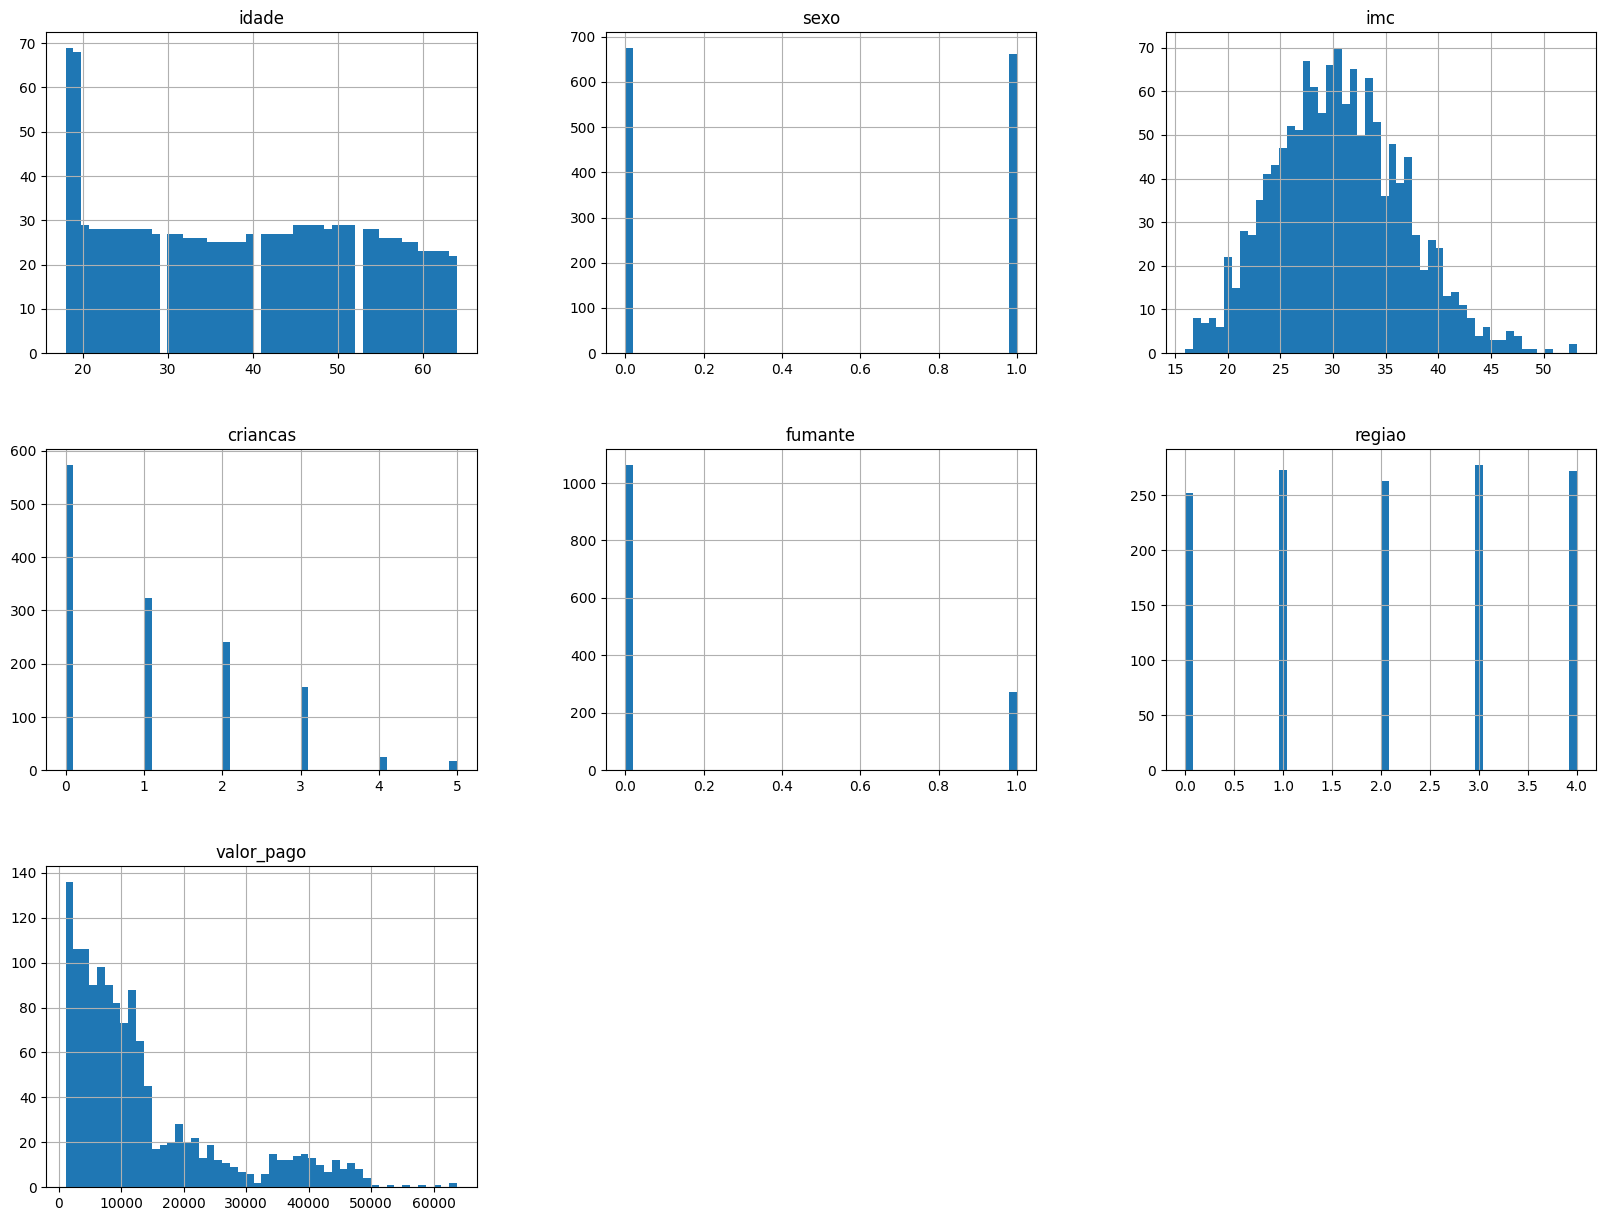

In [24]:
dataset.hist(bins=50, figsize=(20,15))

In [25]:
import plotly.express as px
px.treemap(dataset, path=['regiao','fumante', 'idade', 'criancas']).show()


## Remover registros distantes (desabilitado)

In [26]:
#dataset = dataset.drop(dataset[dataset['valor_pago'] > 50000].index)

In [27]:
#dataset.hist(bins=50, figsize=(20,15))

## Correlação

In [28]:
dataset.corrwith(dataset['valor_pago'])

idade         0.299008
sexo         -0.057292
imc           0.198341
criancas      0.067998
fumante       0.787251
regiao        0.026892
valor_pago    1.000000
dtype: float64

## Atualizar dados processados (desabilitado)

In [29]:
# dataset.to_csv('../data/processed.csv', index = False)

# Passo 3: Construindo o modelo

## Imports

In [41]:
import pandas as pd

## Obtendo os dados

In [42]:
dataset = pd.read_csv('data/processed.csv')
dataset.head()

,idade,sexo,imc,criancas,fumante,regiao,valor_pago
0,19,1,27.900,0,1,3,16884.92
1,18,0,33.770,1,0,4,1725.55
2,28,0,33.000,3,0,4,4449.46
3,33,0,22.705,0,0,1,21984.47
4,32,0,28.880,0,0,4,3866.86


## Removendo elementos com baixa correlação (desabilitado)

In [43]:
#del dataset['sexo']
#del dataset['regiao']

## Preparação dos dados categóricos

In [44]:
#dataset = pd.get_dummies(dataset, columns=['fumante'], drop_first=True)
dataset = pd.get_dummies(dataset, columns=['sexo', 'fumante', 'regiao'], drop_first=True)

In [45]:
dataset.head()

,idade,imc,criancas,valor_pago,sexo_1,fumante_1,regiao_1,regiao_2,regiao_3,regiao_4
0,19,27.900,0,16884.92,True,True,False,False,True,False
1,18,33.770,1,1725.55,False,False,False,False,False,True
2,28,33.000,3,4449.46,False,False,False,False,False,True
3,33,22.705,0,21984.47,False,False,True,False,False,False
4,32,28.880,0,3866.86,False,False,False,False,False,True


## Separação de variáveis independentes x dependentes

In [46]:
X = dataset.drop('valor_pago', axis=1)
y = dataset['valor_pago']

## Gerando os modelos

In [51]:
# Cross-Validation models.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import operator

# Configuração de KFold.
kfold  = KFold(n_splits=10, shuffle=True)

train_model_linear = TrainModelLinearRegression("linear_regression_model")
train_model_ridge = TrainModelRidgeRegression("ridge_regression_model")
train_model_lasso = TrainModelLassoRegression("lasso_regression_model")
train_model_elastic_net = TrainModelElasticNetRegression("elastic_net_regression_model")
train_model_gradient_boosting = TrainModelGradientBoostingRegressor("gradient_boosting_regressor_model")
train_model_svr = TrainModelSupportVectorRegression("support_vector_regression_model")
train_model_random_forest = TrainModelRandomForestRegressor("random_forest_regressor_model")

train_model_linear.train(X, y, test_size=0.2)
train_model_ridge.train(X, y, test_size=0.2)
train_model_lasso.train(X, y, test_size=0.2)
train_model_elastic_net.train(X, y, test_size=0.2)
train_model_gradient_boosting.train(X, y, test_size=0.2)
train_model_svr.train(X, y, test_size=0.2)
train_model_random_forest.train(X, y, test_size=0.2)

model_linear = train_model_linear.generate_model()
model_ridge = train_model_ridge.generate_model()
model_lasso = train_model_lasso.generate_model()
model_elastic_net = train_model_elastic_net.generate_model()
model_gradient_boosting = train_model_gradient_boosting.generate_model()
model_svr = train_model_svr.generate_model()
model_random_forest = train_model_random_forest.generate_model()

## Comparando modelos

In [52]:
# Applyes KFold to models.
linear_result = cross_val_score(model_linear, X, y, cv = kfold)
ridge_result = cross_val_score(model_ridge, X, y, cv = kfold)
lasso_result = cross_val_score(model_lasso, X, y, cv = kfold)
elastic_net_result = cross_val_score(model_elastic_net, X, y, cv = kfold)
gradient_boosting_result = cross_val_score(model_gradient_boosting, X, y, cv = kfold)
svr_result = cross_val_score(model_svr, X, y, cv = kfold)
random_forest_result = cross_val_score(model_random_forest, X, y, cv = kfold)

dic_models_result = {
    "LINEAR_REGRESSION": linear_result.mean(),
    "RIDGE_REGRESSION": ridge_result.mean(),
    "LASSO_REGRESSION": lasso_result.mean(),
    "ELASTIC_NET_REGRESSION": elastic_net_result.mean(),
    "GRADIENT_BOOSTING_REGRESSOR": gradient_boosting_result.mean(),
    "SVR": svr_result.mean(),
    "RANDOM_FOREST_REGRESSOR": random_forest_result.mean()
}

model_best = max(dic_models_result, key=dic_models_result.get)

# Aqui foi escolhido o Gradient Boosting Regressor para os passos seguintes
print("Melhor modelo é: {0} cujo valor é {1}".format(model_best, dic_models_result[model_best]))

Melhor modelo é: GRADIENT_BOOSTING_REGRESSOR cujo valor é 0.8539580321365907


## Checando proporção

In [53]:
X_train, X_test, y_train, y_test = train_model_gradient_boosting.get_train_result()

1070 training + 268 tests
1070 training + 268 tests


In [54]:
X_train["fumante_1"].value_counts() / len(X_train)

fumante_1
False    0.794393
True     0.205607
Name: count, dtype: float64

In [55]:
X_test["fumante_1"].value_counts() / len(X_test)

fumante_1
False    0.798507
True     0.201493
Name: count, dtype: float64

## Avaliando o modelo

In [57]:
train_model_gradient_boosting.evaluate()

gradient_boosting_regressor_model
Mean squared error: 19144452.63209089
Sqrt Mean squared error: 4375.4374218003495
R2 score: 0.8766852898586742
Mean absolute error: 2469.7655137065863
MAPE: 30.16%


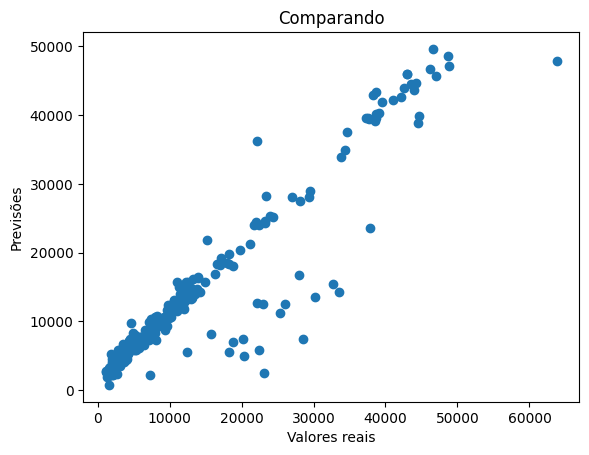

In [58]:
train_model_gradient_boosting.evaluate_pred()

## Salvando o modelo (para ser utilizado pelo app)

In [59]:
train_model_gradient_boosting.save()

Saved model: gradient_boosting_regressor_model.pkl


## Salvando os dados finais utilizado pelo modelo

In [60]:
#dataset = dataset.drop(columns=['valor_pago'])
dataset.to_csv("data/final.csv", index=False)

# App UI

## Start App

In [ ]:
build_and_start_app()